# Imports

In [15]:
import gensim
import ujson as json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import logging
sns.set(style='white', context='notebook', rc={'figure.figsize':(14,10)})
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [2]:
LOAD_FROM_FILE = True
DATAFRAME_FILE = 'data/flavor_space.pickle'
MODEL_FILE = 'data/flavor2vec.model'

# Prepare datasets

In [3]:
if LOAD_FROM_FILE:
    df = pd.read_pickle(DATAFRAME_FILE)
else:
    with open('data/full_set.json') as f:
        data = json.load(f)
        df = pd.json_normalize(data)
        df = df.astype({'id': 'string'})
        # Construct Molecule vectors
        df['mols'] = df['flavor_molecules'].apply(lambda el: [str(m['pubchem_id']) for m in el])
        # Build Tagged Document Corpus
        df['mol_doc'] = df.apply(lambda r: gensim.models.doc2vec.TaggedDocument(r['mols'], [r['id']]), axis=1)
        df['type'] = 'recipe'

    with open('data/flavor_DB.json') as f:
        data = json.load(f)
        flavor_df = pd.json_normalize(data)
        flavor_df = flavor_df.rename(columns={'entity_id': 'id', 'entity_alias_readable': 'food'})
        flavor_df['id'] = flavor_df['id'].apply(lambda i: f"ing-{i}" )
        # Construct Document vectors
        flavor_df['mols'] = flavor_df['molecules'].apply(lambda el: [str(m['pubchem_id']) for m in el])
        # Build Tagged Document Corpus
        flavor_df['mol_doc'] = flavor_df.apply(lambda r: gensim.models.doc2vec.TaggedDocument(r['mols'], [r['id']]), axis=1)
        # Annotate documnet lengths
        flavor_df['molecules_count'] = flavor_df['mols'].apply(lambda el: len(el))
        flavor_df['type'] = 'ingredient'


    df = pd.concat([df, flavor_df])
    df.reset_index(drop=True, inplace=True)
    del flavor_df

# HyperParameters

In [4]:
MODEL = 0 # PV-DBOW
VECTOR_SIZE = 300
WINDOW_SIZE = df['molecules_count'].max() 
EPOCHS = 40
DIM_REDUCTION = 3

# Train Model

In [5]:
if LOAD_FROM_FILE:
    model = gensim.models.doc2vec.Doc2Vec.load(MODEL_FILE)
else:
    model = gensim.models.doc2vec.Doc2Vec(dm=MODEL, vector_size=VECTOR_SIZE, window=WINDOW_SIZE, epochs=EPOCHS)
    model.build_vocab(df['mol_doc'])
    model.train(df['mol_doc'], total_examples=model.corpus_count, epochs=model.epochs)
    model.save(MODEL_FILE)

2021-11-23 13:22:14,959 : INFO : loading Doc2Vec object from data/flavor2vec.model
2021-11-23 13:22:15,016 : INFO : loading dv recursively from data/flavor2vec.model.dv.* with mmap=None
2021-11-23 13:22:15,017 : INFO : loading vectors from data/flavor2vec.model.dv.vectors.npy with mmap=None
2021-11-23 13:22:15,062 : INFO : loading wv recursively from data/flavor2vec.model.wv.* with mmap=None
2021-11-23 13:22:15,064 : INFO : setting ignored attribute cum_table to None
2021-11-23 13:22:15,076 : INFO : Doc2Vec lifecycle event {'fname': 'data/flavor2vec.model', 'datetime': '2021-11-23T13:22:15.076657', 'gensim': '4.1.2', 'python': '3.9.7 (default, Sep 16 2021, 08:50:36) \n[Clang 10.0.0 ]', 'platform': 'macOS-10.14.6-x86_64-i386-64bit', 'event': 'loaded'}


# Random Flavor Neighborhood

In [9]:
def random_suggestion():
    row = df.sample(n=1)
    flavor_vec = model.infer_vector(row.iloc[0]['mol_doc'].words)
    similars = model.dv.most_similar(flavor_vec)
    s_df = pd.DataFrame(similars, columns=['id','similarity']).astype({'id': 'string'})
    return pd.concat([row[['id','food']], s_df.merge(df, on='id', how='left')[['id','similarity','food']] ])

random_suggestion()

,id,food,similarity
19867,641e0d3c96,Camote Almendrado - Sweet Potato With Almonds,NaN
0,641e0d3c96,Camote Almendrado - Sweet Potato With Almonds,0.926492
1,1e3ec8e5cf,Brownie Cookie Dough Swirl Protein Balls,0.860082
2,63e2e08de5,Dianna's Macaroons,0.775461
3,64e2309c57,Almond Splinters,0.774584
4,57ca2166d6,Badam Katlee,0.774459
5,453d2385e8,French Cream Almondine,0.772742
6,ba0afdf30b,Almond Joy Candies,0.771089
7,3167fb7e88,Kalakand,0.769406
8,705e027946,Almond Butter Hot Chocolate Recipe,0.768806


# Identity Accuracy (Top-k ROC)

In [10]:
from collections import defaultdict

def roc(df, max_topn=2):
    """
    returns: [(k, TPR, FPR)...]
    """
    total = len(df)
    accuracy = defaultdict(lambda: defaultdict(int)) # {topn: (tp, fp) }
    for i,row in df.iterrows():
        flavor_vec = model.infer_vector(row['mol_doc'].words)
        similars = model.dv.most_similar(flavor_vec, topn=max_topn)
        for j,s in enumerate(similars):
            t = j+1
            if row['id'] == s[0]:                    
                for tt in range(t,max_topn+1):
                    accuracy[tt]['tp'] += 1                
                break
            else:
                accuracy[t]['fp'] += 1        
    return pd.DataFrame(
        [(i, accuracy[i]['tp']/total, accuracy[i]['fp']/total) for i in range(1, max_topn+1)],
        columns=["top-k", "TPR", "FPR"]
    )

roc_df = roc(df, max_topn=25)

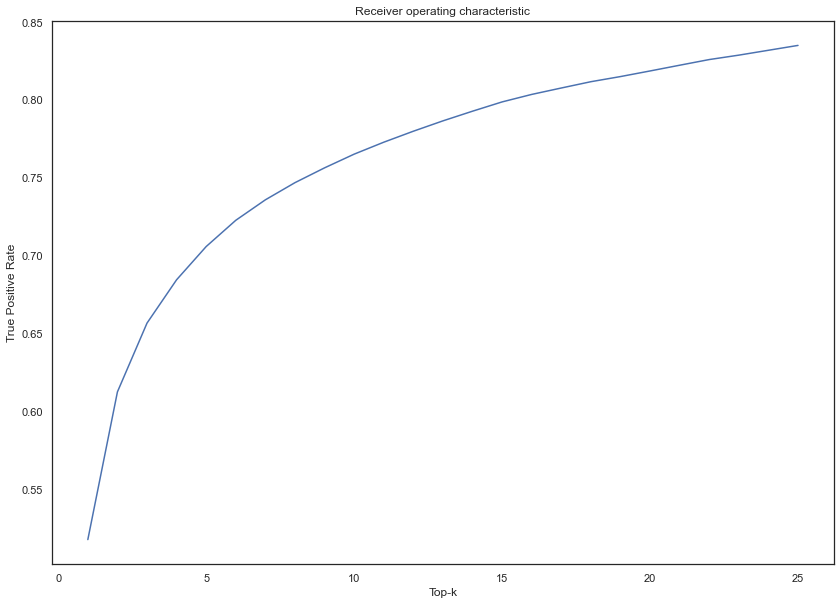

In [16]:
plt.plot(roc_df['top-k'], roc_df['TPR'])
plt.xlabel("Top-k")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic")
plt.show()

# Dimensional Reduction

In [17]:
import umap.umap_ as umap

In [18]:
reducer = umap.UMAP(n_components=DIM_REDUCTION)
projection = reducer.fit_transform(model.dv.vectors) # model.dv.index_to_key 
projection

array([[ 9.817434  ,  4.3402233 , 15.113898  ],
       [ 7.214039  ,  9.424209  , 11.670061  ],
       [ 9.00738   ,  6.3068476 ,  7.2865553 ],
       ...,
       [ 8.875652  , 12.135397  ,  0.9600899 ],
       [ 8.866295  , 12.130869  ,  0.9654839 ],
       [ 8.742109  , 12.124755  ,  0.93038535]], dtype=float32)

# Visualize Flavor Space

In [50]:
from bokeh.application import Application
from bokeh.application.handlers import FunctionHandler
from bokeh.layouts import column, row
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import ( 
    HoverTool, ColumnDataSource, Callback, DataTable, TableColumn,
    CustomJS, CategoricalColorMapper, CategoricalMarkerMapper, LinearColorMapper
)
from bokeh.transform import linear_cmap
from bokeh.palettes import Cividis256, Magma256
from bokeh.models.widgets import Slider, TextInput, Select, AutocompleteInput

logging.getLogger('bokeh').setLevel(logging.CRITICAL)
logging.getLogger('tornado').setLevel(logging.CRITICAL)

output_notebook()

Loading BokehJS ...

In [51]:
# Debug: check flavor space
# plt.scatter(projection[:,0], projection[:,1])

In [60]:
SPACE_SIZE = 10000
projection_df = pd.DataFrame(projection[:SPACE_SIZE], columns=('x', 'y', 'z'))
projection_df['id'] = model.dv.index_to_key[:SPACE_SIZE]
projection_df['food'] = df['food'][:SPACE_SIZE]
projection_df['type'] = df['type'][:SPACE_SIZE]
projection_df['ingredient'] = df['unique_ingredient'][:SPACE_SIZE]
projection_df['ingredient_count'] = df['ingredient_count'][:SPACE_SIZE]
selected_indexes = []

In [61]:
## find nearest neighbors
def findSimilars(food="", type_="recipe", limit=0):
    if food == "":
        return projection_df, pd.DataFrame(columns=projection_df.columns)
    if not type_ in ["recipe", "ingredient", "all"]:
        raise Exception("Wrong food type, type must be one of 'recipe, ingredient, all' ")
    i=3
    row = df.loc[df['food']==food]
    flavor_vec = model.infer_vector(row.iloc[0]['mol_doc'].words)
    similars = model.dv.most_similar(positive=[flavor_vec],topn=30)
    indices = [x[0] for x in similars]
    indices.append(row["id"].iloc[0])
    selected_df = projection_df[projection_df["id"].isin(indices)]
    selected_df = selected_df[selected_df["type"] == type_]
    if type_ == 'recipe':
        selected_df = selected_df[selected_df['ingredient_count'] > limit]
    selected_df = selected_df.iloc[:5]
    nonselected_df = projection_df[~projection_df["id"].isin(selected_df['id'])]
    return nonselected_df, selected_df

In [62]:
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)                 

fig = figure(
    title='UMAP projection of the Flavor Space',
    plot_width=800,
    plot_height=800,
    tools=('pan, wheel_zoom, reset, lasso_select')
)

fig.add_tools(HoverTool(tooltips="""
<div>
    <div>
        <span style='font-size: 16px; color: #224499'>ID: @id</span>
        <span style='font-size: 18px'>@food</span>
    </div>
</div>
"""))

## prepare data
nonselected_df, selected_df = findSimilars()
chart_data = ColumnDataSource(nonselected_df)
highlighted_data = ColumnDataSource(selected_df)
table_data = ColumnDataSource(dict(id=highlighted_data.data["id"], 
                           food=highlighted_data.data["food"], 
                           type=highlighted_data.data["type"], 
                           ingredient = highlighted_data.data["ingredient"],
                           ingredient_count=highlighted_data.data["ingredient_count"]
                          ))
color_map = LinearColorMapper(palette=Magma256, low=projection_df['z'].min(), high=projection_df['z'].max())
marker_map = CategoricalMarkerMapper(factors=projection_df['type'].unique(), markers=['circle', 'triangle'])

chart = fig.scatter(
    'x',
    'y',
    source=chart_data,
    marker=dict(field='type', transform=marker_map),
    color=dict(field='z', transform=color_map),
    line_alpha=0.6,
    fill_alpha=0.6,
    size=6
)

## drawing scatter of selected data in red color
highlighted_chart = fig.scatter(
    'x',
    'y',
    source=highlighted_data,
    color="red",
    line_alpha=0.6,
    fill_alpha=0.6,
    size=6
)




chart_data.selected.js_on_change('indices', 
     CustomJS(args=dict(chart_data=chart_data, table_data=table_data), 
              code="""
                var selected_indexes = cb_obj.indices;
                console.log(selected_indexes)
                table_data.data['index'] = selected_indexes;
                table_data.data['id'] = [];
                table_data.data['food'] = [];
                table_data.data['ingredient'] = [];
                table_data.data['ingredient_count'] = [];
                table_data.data['type'] = [];
                for (let i=0;i<selected_indexes.length;i++){
                    table_data.data['id'].push(chart_data.data['id'][selected_indexes[i]]);
                    table_data.data['food'].push(chart_data.data['food'][selected_indexes[i]]);
                    table_data.data['type'].push(chart_data.data['type'][selected_indexes[i]]);
                    table_data.data['ingredient'].push(chart_data.data['ingredient'][selected_indexes[i]]);
                    table_data.data['ingredient_count'].push(chart_data.data['ingredient_count'][selected_indexes[i]]);
                }                
                
                // var kernel = IPython.notebook.kernel;
                // IPython.notebook.kernel.execute("selected_indexes = " + selected_indexes);
                
                table_data.change.emit();
                """
             )
)

## display the selected data
table = DataTable(source=table_data, sizing_mode="stretch_width", columns=[
    TableColumn(field='id'),
    TableColumn(field='food'),
    TableColumn(field='type'),
    TableColumn(field='ingredient'),
    TableColumn(field='ingredient_count')
])

#### config user input widgets
def updateData(food, type_, limit):
    nonselected_df, selected_df = findSimilars(food=food, type_=type_, limit=int(limit))
    # update data
    chart_data.data = nonselected_df
    highlighted_data.data = selected_df
    table_data.data = dict(id=highlighted_data.data["id"], 
                           food=highlighted_data.data["food"], 
                           ingredient = highlighted_data.data["ingredient"],
                           ingredient_count=highlighted_data.data["ingredient_count"],
                           type=highlighted_data.data["type"]
                          )

    
## text input for food input
def text_input_callback(attr, old, new):
    updateData(food=text_input.value, type_=select_type_filter.value, limit=int(select_ingredient_filter.value))

# get all possible entries
recipe_list = df[df['type'] == "recipe"]["food"].tolist()
ingr_list = df[df['type'] == "ingredient"]["food"].tolist()

text_input = AutocompleteInput(title="Food Name", value='', completions=recipe_list, case_sensitive=False)       
text_input.on_change("value",text_input_callback)


## filtration food with only 1 or 2 ingredients
def ingredient_filter_callback(attr, old, new):
    updateData(food=text_input.value, type_=select_type_filter.value, limit=int(select_ingredient_filter.value))

select_ingredient_filter = Slider(start=0, end=5, value=0, step=1, title="Food with at least N ingredients")
select_ingredient_filter.on_change("value", ingredient_filter_callback)


## type filtration
def type_filter_callback(attr, old, new):
    if select_type_filter.value == 'recipe':
        text_input.completions = recipe_list
    else:
        text_input.completions = ingr_list
    text_input.value = ""
    updateData(food=text_input.value, type_=select_type_filter.value, limit=int(select_ingredient_filter.value))
    
select_type_filter = Select(title="Food type", value="recipe", options=["recipe", "ingredient"])
select_type_filter.on_change("value", type_filter_callback)


## Nutrition Optimizer
def nutrition_filter_callback(attr, old, new):
    ###############
    #### placeholder optimization algorithm here
    ##############
    print(select_nutrition_filter.value)    
select_nutrition_filter = Select(title="Nutrition Priority", value="Protein", options=["Protein", "Fat", "Calories"])
select_nutrition_filter.on_change("value", nutrition_filter_callback)


# Set up layouts and add to document
# layout = column(row(text_input, select_ingredient_filter, select_nutrition_filter),fig, table)
layout = column(row(column( select_type_filter, text_input), 
                    column(select_ingredient_filter,select_nutrition_filter)),
                fig, table)


def modify_doc(doc):
    doc.add_root(row(layout, width=800))
    return doc


handler = FunctionHandler(modify_doc) # A Handler that accepts a plain python function to use for modifying Bokeh Documents.
app = Application(handler)
show(app)

# Clustering Analysis

In [36]:
from sklearn.cluster import DBSCAN
from mpl_toolkits.mplot3d import Axes3D

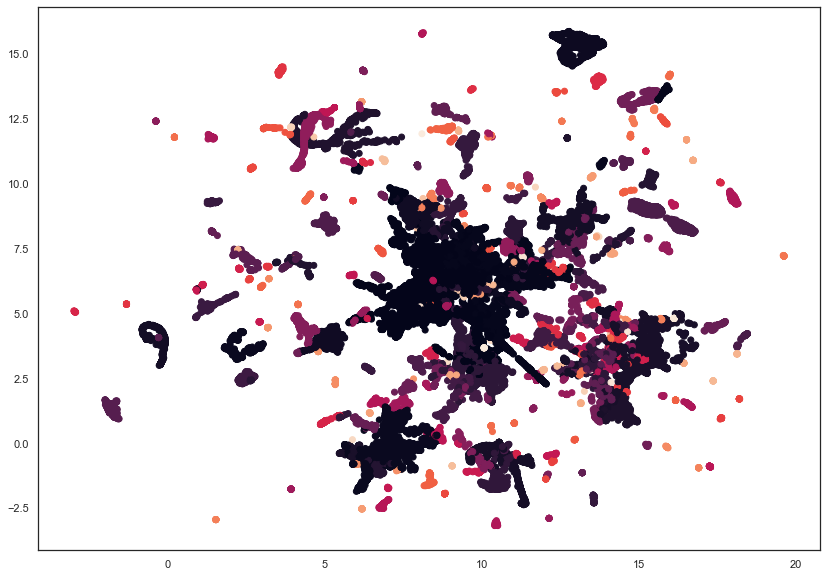

In [37]:
clustering = DBSCAN(eps=.3, min_samples=1).fit(projection_df[['x','y','z']])
clustered = clustering.fit_predict(projection_df[['x','y','z']])


plt.scatter(projection_df['x'], projection_df['y'], c=clustered)

# fig = plt.figure()
# ax = Axes3D(fig)
# ax.scatter(projection_df['x'],projection_df['y'],projection_df['z'], c=clustered)
# ax.view_init(azim=200)

# "Tastes like Chicken!"

In [38]:
def ingredient_present(row, term=''):
    if type(row) == float:
        return True
    
    for el in row:
        if term in el:
            return True
    return False

def tastes_like(flavor_index, exclude_ingredient, topn=5):
    row = df.iloc[flavor_index]
    flavor_vec = model.dv.vectors[flavor_index]
    df['_sim'] = model.dv.most_similar(flavor_vec, topn=None)
    df['_present'] = df['unique_ingredient'].apply(ingredient_present, term=exclude_ingredient.lower())    
    return df[~df._present].sort_values(['_sim'], ascending=False)[:topn]
     

In [39]:
QUERY_INDEX = 51507
df.iloc[QUERY_INDEX][['id','food','unique_ingredient']]

id                   ing-272
food                 Chicken
unique_ingredient        NaN
Name: 51507, dtype: object

In [40]:
tastes_like(QUERY_INDEX, exclude_ingredient='Chicken', topn=10)[['id','food','unique_ingredient','_sim']]

,id,food,unique_ingredient,_sim
47916,ef4a9bec66,Bbq rotisserie smoked turkey,"[ground turkey, raw]",0.534512
46349,e768b479b4,Thankgiving Day Turkey,"[ground turkey, raw, water, bottled, generic, ...",0.533408
50751,fd74454535,Cajun Deep Fried Turkey (Houston Chronicle) Re...,"[ground turkey, raw]",0.529180
46151,e67b50494c,Gorilla Fart,"[alcoholic beverage, distilled, rum, 80 proof,...",0.528323
45523,e35bc46e21,Flaming Orgy,"[ground turkey, raw, alcoholic beverage, disti...",0.524276
14509,48a9f25708,Easy 3-Minute Microwave Caramel Sauce,"[sugars, granulated, water, bottled, generic]",0.511129
33357,a643679b3e,Reuben Sandwich,"[ground turkey, raw]",0.510742
43140,d7c5341369,Desert Fire,"[alcoholic beverage, tequila sunrise, canned, ...",0.509866
6633,20b9cde664,Recipe no longer on file Recipe aricat,"[water, bottled, generic]",0.507073
11117,3778c7e07e,Toffees,"[sugars, granulated, water, bottled, generic, ...",0.504166


# Flavor Math!

In [41]:
df[df['food'].str.contains('Turkey')]

,id,food,unique_ingredient,ingredient_count,category_freq,instructions,flavor_molecules,molecules_count,nutr_values_per100g.energy,nutr_values_per100g.fat,...,category_readable,entity_alias_basket,natural_source_name,entity_alias,molecules,natural_source_url,entity_alias_url,entity_alias_synonyms,_sim,_present
47,0038bb9065,Hearty Cheese (And Turkey) Soup,"[ground turkey, raw, onions, raw, potatoes, ra...",13.0,"[{'additive': 1}, {'cerealcrop-cereal': 1}, {'...","[{'text': 'In a nonstick skillet, cook turkey ...","[{'ingredient_flavorDB': 'Pepper', 'fooddb_id'...",677,113.182395,4.475159,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.124898,True
364,01c552a0ae,Golden Roast Turkey,"[ground turkey, raw, butter, without salt, sal...",4.0,"[{'additive': 1}, {'dairy': 1}, {'meat': 1}, {...",[{'text': 'Remove giblets and neck from turkey...,"[{'ingredient_flavorDB': 'Pepper', 'fooddb_id'...",336,165.286186,9.887603,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.169875,False
895,044f165d49,Simple Stuffed Roast Turkey,"[ground turkey, raw, salt, table, oil, corn, p...",3.0,"[{'additive': 1}, {'cerealcrop-maize': 1}, {'m...",[{'text': 'Rinse turkey inside and out with wa...,"[{'ingredient_flavorDB': 'Corn Oil', 'fooddb_i...",62,149.043265,7.817208,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.332804,False
1053,0516fb6bb1,Cranberry Turkey,"[ground turkey, raw, oil, olive, salad or cook...",5.0,"[{'fruit': 1}, {'fruit-berry': 1}, {'meat': 1}...","[{'text': 'In a large skillet, cook turkey in ...","[{'ingredient_flavorDB': 'Mustard', 'fooddb_id...",330,168.371606,6.179970,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.141974,False
1110,05532f435e,Sweet Italian Turkey Sausage,"[ground turkey, raw, spices, basil, dried, sug...",10.0,"[{'additive': 2}, {'herb': 3}, {'meat': 1}, {'...",[{'text': 'Combine all ingredients an mix thor...,"[{'ingredient_flavorDB': 'Pepper', 'fooddb_id'...",390,194.235303,10.172401,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.006209,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50695,fd30e499f5,Breakfast Turkey Sausage Patties,"[ground turkey, raw, spices, cumin seed, spice...",10.0,"[{'cerealcrop-cereal': 1}, {'herb': 3}, {'meat...",[{'text': 'Combine the turkey and dry spices i...,"[{'ingredient_flavorDB': 'Rice', 'fooddb_id': ...",531,228.731287,11.914682,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.359618,True
50751,fd74454535,Cajun Deep Fried Turkey (Houston Chronicle) Re...,"[ground turkey, raw]",1.0,[{'meat': 1}],[{'text': 'In spite of the potential danger of...,"[{'ingredient_flavorDB': 'Turkey', 'fooddb_id'...",17,148.000000,7.660000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.529180,False
50787,fdaddc0c2a,Hearty Turkey Bake,"[potatoes, raw, skin, cheese, cheddar, ground ...",9.0,"[{'additive': 1}, {'dairy': 2}, {'herb': 1}, {...","[{'text': 'Preheat oven to 375F (190C).'}, {'t...","[{'ingredient_flavorDB': 'Potato', 'fooddb_id'...",563,270.161911,24.808146,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.174996,True
51515,ing-280,Turkey,NaN,NaN,NaN,NaN,NaN,17,NaN,NaN,...,Meat,"turkey, turkey-cooked, turkey-roasted",Domesticate Turkey,turkey,"[{'bond_stereo_count': 0, 'undefined_atom_ster...",https://en.wikipedia.org/wiki/Domesticated_turkey,https://en.wikipedia.org/wiki/Turkey_meat,Turkey,0.527499,True


In [42]:
df.iloc[[51507, 51515]]

,id,food,unique_ingredient,ingredient_count,category_freq,instructions,flavor_molecules,molecules_count,nutr_values_per100g.energy,nutr_values_per100g.fat,...,category_readable,entity_alias_basket,natural_source_name,entity_alias,molecules,natural_source_url,entity_alias_url,entity_alias_synonyms,_sim,_present
51507,ing-272,Chicken,NaN,NaN,NaN,NaN,NaN,131,NaN,NaN,...,Meat,"chicken, chicken-boiled, chicken-broth, chicke...",Fowl,chicken,"[{'bond_stereo_count': 2, 'undefined_atom_ster...",https://en.wikipedia.org/wiki/Fowl,https://en.wikipedia.org/wiki/Chicken,Chicken,1.000000,True
51515,ing-280,Turkey,NaN,NaN,NaN,NaN,NaN,17,NaN,NaN,...,Meat,"turkey, turkey-cooked, turkey-roasted",Domesticate Turkey,turkey,"[{'bond_stereo_count': 0, 'undefined_atom_ster...",https://en.wikipedia.org/wiki/Domesticated_turkey,https://en.wikipedia.org/wiki/Turkey_meat,Turkey,0.527499,True


In [43]:
similars = model.dv.most_similar(model.dv.vectors[51507] - model.dv.vectors[51515])
s_df = pd.DataFrame(similars, columns=['id','similarity']).astype({'id': 'string'})
s_df.reset_index().merge(df, on='id', how='left')[['id','similarity','food']]

,id,similarity,food
0,08f2a0465c,0.727479,Grilled Chipotle and Cola BBQ Chicken
1,ing-272,0.725266,Chicken
2,0858b28796,0.724751,Giblet Gravy (For Poultry)
3,25bd97110f,0.721797,Basic Chicken Stock
4,205c598aec,0.719243,Stove Top Easy Chicken Bake
5,1edf9efbc9,0.718560,BBQ Grilled Chicken Kabobs
6,148b1b6b24,0.716247,BBQ Grilled Chicken Kabobs
7,eb2b5633db,0.715275,Mexican Style Chicken
8,1c993c47d9,0.713281,Grilled Chipotle and Cola BBQ Chicken
9,eca3abce74,0.712342,Crockpot BBQ Chicken


# Save Artifacts

In [25]:
# df.drop(columns=[c for c in df.columns if c.startswith('_')]).to_pickle(DATAFRAME_FILE)